In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
from time import time

import matplotlib.ticker as tkr
import matplotlib.pyplot as plt

from scipy import stats
from sklearn import preprocessing
    
import math
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model

In [29]:
train_df = pd.read_csv('trainset.csv')

In [30]:
train_df.head()

Date        Open        High         Low       Close   Adj Close  \
0  2013-01-02  357.385559  361.151062  355.959839  359.288177  359.288177   
1  2013-01-03  360.122742  363.600128  358.031342  359.496826  359.496826   
2  2013-01-04  362.313507  368.339294  361.488861  366.600616  366.600616   
3  2013-01-07  365.348755  367.301056  362.929504  365.001007  365.001007   
4  2013-01-08  365.393463  365.771027  359.874359  364.280701  364.280701   

    Volume  
0  5115500  
1  4666500  
2  5562800  
3  3332900  
4  3373900

In [31]:
train_df = train_df.set_index("Date")
train_df.shape

(1259, 6)

In [32]:
train_df.head()

Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-01-02  357.385559  361.151062  355.959839  359.288177  359.288177   
2013-01-03  360.122742  363.600128  358.031342  359.496826  359.496826   
2013-01-04  362.313507  368.339294  361.488861  366.600616  366.600616   
2013-01-07  365.348755  367.301056  362.929504  365.001007  365.001007   
2013-01-08  365.393463  365.771027  359.874359  364.280701  364.280701   

             Volume  
Date                 
2013-01-02  5115500  
2013-01-03  4666500  
2013-01-04  5562800  
2013-01-07  3332900  
2013-01-08  3373900

In [36]:
lstm_y = train_df['Close'].values 
lstm_y = lstm_y.astype('float32')
lstm_y = np.reshape(lstm_y, (-1, 1))
scaler = MinMaxScaler(feature_range=(0, 1))
lstm_y = scaler.fit_transform(lstm_y)

In [37]:
percent_of_training = 0.7
train_size = int(len(lstm_y) * percent_of_training)
test_size = len(lstm_y) - train_size

In [38]:
train_y, test_y = lstm_y[0:train_size,:], lstm_y[train_size:len(lstm_y),:]

In [39]:
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

In [40]:
look_back = 7

In [41]:
X_train_features_1, y_train = create_dataset(train_y, look_back)
X_test_features_1, y_test = create_dataset(test_y, look_back)

In [42]:
X_train_features = np.reshape(X_train_features_1, (X_train_features_1.shape[0], 1, X_train_features_1.shape[1]))
X_test_features  = np.reshape(X_test_features_1, (X_test_features_1.shape[0], 1, X_test_features_1.shape[1]))

In [48]:
model = Sequential()
model.add(LSTM(200, input_shape=(X_train_features.shape[1], X_train_features.shape[2])))
model.add(Dropout(0.20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train_features,y_train, epochs=300, batch_size=25, validation_data=(X_test_features, y_test),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0, shuffle=False)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 200)               166400    
_________________________________________________________________
dropout_5 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 166,601
Trainable params: 166,601
Non-trainable params: 0
_________________________________________________________________


In [49]:
train_predict = model.predict(X_train_features)
test_predict  = model.predict(X_test_features)

In [50]:
print('Train Mean Absolute Error:', mean_absolute_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_train,(y_train.shape[0],1)), train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(np.reshape(y_test,(y_test.shape[0],1)), test_predict[:,0])))

Train Mean Absolute Error: 0.014597074
Train Root Mean Squared Error: 0.019051783
Test Mean Absolute Error: 0.024788849
Test Root Mean Squared Error: 0.031524155


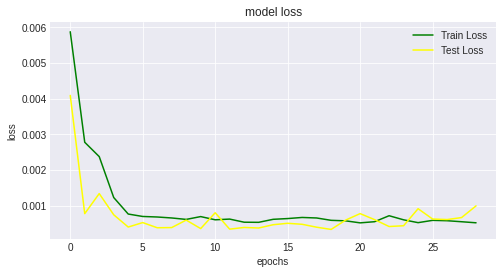

In [51]:
plt.figure(figsize=(8,4))
plt.style.use('seaborn-dark')

plt.plot(history.history['loss'], label='Train Loss',color="green")
plt.plot(history.history['val_loss'], label='Test Loss',color = "yellow")
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(loc='upper right')
plt.grid()

plt.show();

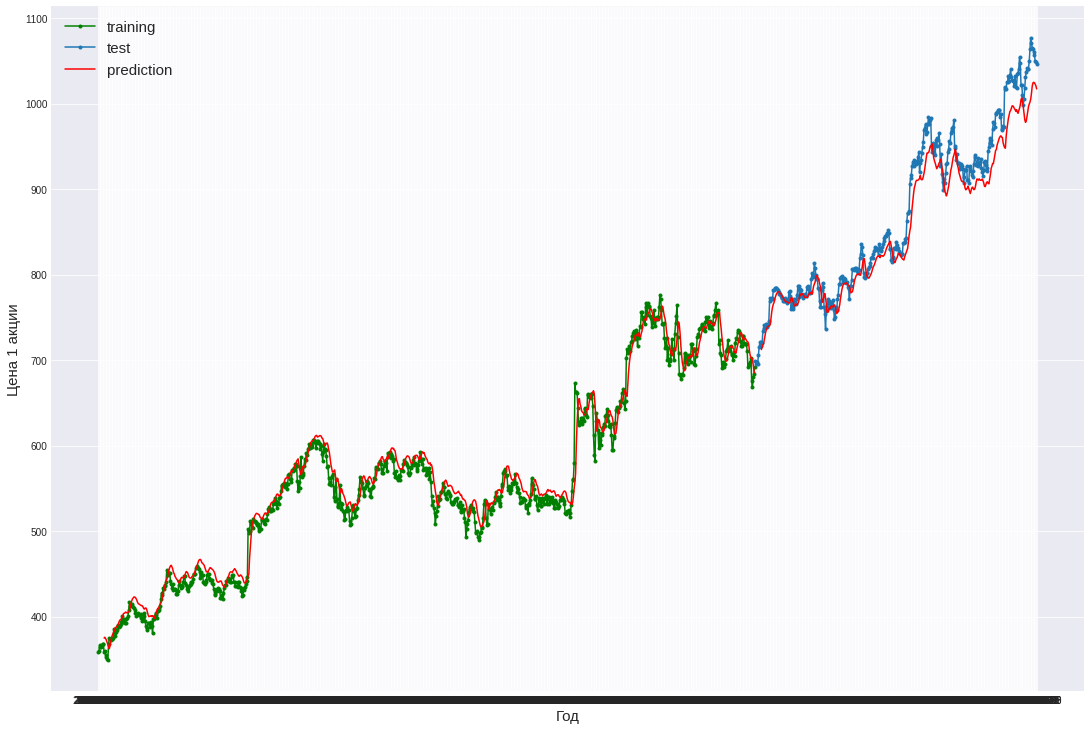

In [53]:
time_y_train = pd.DataFrame(data = scaler.inverse_transform(train_y), index = train_df[0:train_size].index,columns= [""])
time_y_test  = pd.DataFrame(data =scaler.inverse_transform(test_y), index = train_df[train_size:].index,columns= [""])

time_y_train_prediction = pd.DataFrame(data = scaler.inverse_transform(train_predict), index = time_y_train[8:].index,columns= [""])
time_y_test_prediction  = pd.DataFrame(data = scaler.inverse_transform(test_predict), index = time_y_test[8:].index,columns= [""])


plt.style.use('seaborn-dark')
plt.figure(figsize=(15,10))

plt.plot(time_y_train,label = "training",color ="green",marker='.')
plt.plot(time_y_test,label = "test",marker='.')
plt.plot(time_y_train_prediction,color="red",label = "prediction")
plt.plot(time_y_test_prediction,color="red")
plt.tight_layout()
sns.despine(top=True)
plt.ylabel('Цена 1 акции', size=15)
plt.xlabel('Год', size=15)
plt.legend(fontsize=15)
plt.grid()

plt.show();